In [1]:
!pip install langgraph

  Using cached xxhash-3.5.0-cp310-cp310-win_amd64.whl.metadata (13 kB)
Using cached xxhash-3.5.0-cp310-cp310-win_amd64.whl (30 kB)

   -------------------------- ------------- 4/6 [langgraph-prebuilt]
   --------------------------------- ------ 5/6 [langgraph]
   ---------------------------------------- 6/6 [langgraph]



## TypedDict
- `dict`에서는 런타임에 타입 검사를 하지 않는 반면에 `TypedDict`은 정적 타입 검사를 통해 오류를 미리 잡을 수 있음
- `TypedDict`는 각 키에 대해 구체적인 타입을 지정할 수 있고 키를 추가하거나 제거하는 것에 엄격하여 오류 발생 가능 

In [3]:
from typing import Dict, TypedDict 

sample_dict: Dict[str, str] = {
    "name" : "hyun",
    "age" : "30",
    "hobby" : "soccer",
}

sample_dict

{'name': 'hyun', 'age': '30', 'hobby': 'soccer'}

In [ ]:
sample_dict['age'] = 35 # string에서 integer로 값을 변경하여도 오류 X; TypedDict은 오류 발생 
sample_dict['job'] = "AI engineer"

sample_dict

{'name': 'hyun', 'age': 35, 'hobby': 'soccer', 'job': 'AI engineer'}

In [11]:
class Person(TypedDict):
    # 각 키에 대해 구체적인 타입 지정 가능 
    name: str
    age: int
    hobbty: str 
    
typed_dict: Person = {"name": "young", "age" : 25, "hobby" : "basketball"}
typed_dict

{'name': 'young', 'age': 25, 'hobby': 'basketball'}

## Annotated 

타입 힌트에 메타데이터를 추가할 수 있게 하여 코드에 대한 추가 설명을 타입 힌트에 직접 포함 가능

- `name: Annotated[str, "이름"]`
- `age: Annotated[int, '나이']`

In [14]:
from typing import Annotated

name: Annotated[str, "사용자 이름"]
age: Annotated[int, "사용자 나이 (10 ~ 150)"]

In [ ]:
# Pydantic과 결합하여 사용 가능 
from pydantic import Field, BaseModel, ValidationError

class Employee(BaseModel):
    id: Annotated[int, Field(..., description = "직원 ID")]
    name: Annotated[str, Field(..., min_length=3, max_length=50, description="이름")]

## StateGraph 생성

In [1]:
from typing import Annotated, TypedDict
from dotenv import load_dotenv

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver
import os

load_dotenv("../../.env")
api_key = os.getenv("OPENAI_API_KEY")

class State(TypedDict):
    # add_messages는 리듀서 함수인데, 기존 메모리에 새 메시지를 추가하도록 지시
    # 주석이 없는 키는 갱신마다 가장 최근의 값이 저장됨 
    messages: Annotated[list, add_messages]
    
builder = StateGraph(State)

In [2]:
model = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 0.7
)

# 챗봇 노드 정의 및 추가 
def chatbot(state: State):
    answer = model.invoke(state['messages'])
    return {"messages": [answer]}

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드 추가 
builder.add_node('chatbot', chatbot)

In [3]:
# 엣지를 추가하여 작업 시작 위치와 종료 위치 전달 
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile() # 컴파일하여 Runnable 객체로 전환 

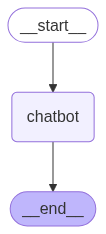

In [4]:
graph

In [14]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 서울에는 다양한 맛집이 많이 있지만, 아래는 유명한 맛집 TOP 10을 추천해 드립니다. 각 식당은 고유의 매력을 가지고 있으니 참고하시기 바랍니다.

1. **광장시장** - 전통 시장으로, 다양한 한국 길거리 음식을 맛볼 수 있습니다. 특히 빈대떡과 마약김밥이 유명합니다.

2. **삼청동 수제비** - 쫄깃한 수제비와 시원한 국물이 인기인 곳으로, 아늑한 분위기에서 식사를 즐길 수 있습니다.

3. **명동교자** - 칼국수와 만두가 유명한 맛집으로, 깊고 진한 국물 맛이 일품입니다.

4. **갈비집** - 한우 갈비가 유명한 식당으로, 고품질의 고기를 즐길 수 있는 곳입니다. 예약을 권장합니다.

5. **이태원부대찌개** - 부대찌개가 유명한 곳으로, 푸짐한 양과 맛있는 국물로 사랑받고 있습니다.

6. **토속촌 삼계탕** - 전통 삼계탕 전문점으로, 건강한 한 끼를 원하신다면 추천드립니다.

7. **부촌수제비** - 수제비와 함께 다양한 찌개를 제공하는 곳으로, 푸짐한 양과 맛이 특징입니다.

8. **오장동 함흥냉면** - 함흥냉면이 유명한 곳으로, 쫄깃한 면발과 시원한 육수가 일품입니다.

9. **김밥천국** - 저렴하면서도 맛있는 김밥을 즐길 수 있는 곳으로, 다양한 메뉴가 있습니다.

10. **홍대 소고기 뚝배기** - 고소한 소고기 뚝배기와 함께 밥을 즐길 수 있는 맛집으로, 친구들과 함께 가기 좋은 곳입니다.

각 맛집은 방문 시 대기 시간이 있을 수 있으니 미리 확인하시고 가시는 것을 추천드립니다. 맛있는 식사 되세요!


In [13]:
input_ = {'messages':[HumanMessage('안녕하세요~!')]}

for chunk in graph.stream(input_):
    print(chunk['chatbot']['messages'][0].content)

안녕하세요! 어떻게 도와드릴까요?


### StateGraph에 메모리 기능 추가

- `thread`: 랭그래프에서는 특정 상호작용 기록을 각 사용자별 thread에 포함하여 기록한다. 따라서 여러 사용자가 혼동 없이 동시에 독자적인 대화를 진행할 수 있다.

In [15]:
from langgraph.checkpoint.memory import MemorySaver

# 이렇게 하면 각 단계가 종료될때마다 state가 기록되어서 최초 실행 이후의 모든ㄷ 호출은 백지 상태로 시작하지 않음
graph = builder.compile(checkpointer=MemorySaver())

In [16]:
thread1 = {'configurable': {'thread_id' : 1}}

result_1 = graph.invoke({
    "messages" : [HumanMessage("안녕하세요, 저는 Hyun 입니다~")]}, thread1)

result_2 = graph.invoke({
    "messages": [HumanMessage('제 이름이 뭐죠?')]}, thread1)

In [17]:
result_1

{'messages': [HumanMessage(content='안녕하세요, 저는 Hyun 입니다~', additional_kwargs={}, response_metadata={}, id='bd84069f-c0b1-4f16-adb1-83b0fd93946a'),
  AIMessage(content='안녕하세요, Hyun님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 15, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByCUc5m8cHDRJk2IiGojWpBkPv95c', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3f1ab6c4-a11b-4579-967e-d9e7dbd2d405-0', usage_metadata={'input_tokens': 15, 'output_tokens': 14, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [18]:
result_2

{'messages': [HumanMessage(content='안녕하세요, 저는 Hyun 입니다~', additional_kwargs={}, response_metadata={}, id='bd84069f-c0b1-4f16-adb1-83b0fd93946a'),
  AIMessage(content='안녕하세요, Hyun님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 15, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByCUc5m8cHDRJk2IiGojWpBkPv95c', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3f1ab6c4-a11b-4579-967e-d9e7dbd2d405-0', usage_metadata={'input_tokens': 15, 'output_tokens': 14, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='제 

In [31]:
graph.get_state(thread1) # 상태 확인 

StateSnapshot(values={'messages': [HumanMessage(content='안녕하세요, 저는 Hyun 입니다~', additional_kwargs={}, response_metadata={}, id='494890ad-18ff-48a6-8764-5a832e792ce7'), AIMessage(content='안녕하세요, Hyun님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 15, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByBuecd4biy6hmAGa6W5wcgCjrAnX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6f8fd5ca-0ddf-4f7e-a678-2406b3936bbf-0', usage_metadata={'input_tokens': 15, 'output_tokens': 14, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMe

In [ ]:
# 상태 업데이트 가능 
graph.update_state(thread1, {'messages': HumanMessage('전 LLM에 관심이 많습니다')})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06b7f1-00d8-6167-8005-0ffe0b547867'}}

In [33]:
graph.get_state(thread1)

StateSnapshot(values={'messages': [HumanMessage(content='안녕하세요, 저는 Hyun 입니다~', additional_kwargs={}, response_metadata={}, id='494890ad-18ff-48a6-8764-5a832e792ce7'), AIMessage(content='안녕하세요, Hyun님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 15, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByBuecd4biy6hmAGa6W5wcgCjrAnX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6f8fd5ca-0ddf-4f7e-a678-2406b3936bbf-0', usage_metadata={'input_tokens': 15, 'output_tokens': 14, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMe

## 채팅 기록 수정 

대부분의 경우, 채팅 기록 메세지는 모델이 정확한 응답을 생성하는 데 사용할 만큼 좋은 상태나 형식을 갖추지 못한다. 따라서 다음과 같은 방법으로 이를 해결한다. 

- **메세지 축약(trimming)**: LLM에서는 컨텍스트 윈도를 제한하는데, 이는 프롬프트로 입력 가능한 토큰 수에 한계가 존재한다는 의미이다. 실전에서는 최신 메시지만 로드하여 저장하는 정도로도 충분히 문제를 해결할 수 있다. `trim_messages` 메서드를 총해 채팅 기록에서 보존하겆나 삭제할 토큰 수를 지정할 수 있다.

- **내용 필터링(filtering)**

- **메시지 병합(merging)**

In [19]:
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    trim_messages
)

# 간단한 메세지 설정 
messages = [
    SystemMessage(content = "당신은 친절한 어시스턴스입니다."),
    HumanMessage(content='안녕하세요. 저는 Hyun 입니다.'),
    AIMessage(content='안녕하세요!'),
    HumanMessage(content='엔지니어를 희망하고 있어요'),
    AIMessage(content='어떤 분야의 엔지니어를 희망하고 있나요?'),
    HumanMessage(content='AI나 분산처리 분야입니다.'),
    AIMessage(content='좋네요!'),
    HumanMessage(content='1 + 2는 얼마죠?'),
    AIMessage(content='3입니다.'),
    HumanMessage(content="고마워요")
]

trimmer = trim_messages(
    max_tokens = 65, 
    strategy = 'last', # 메세지 목록의 시작 지점 설정, 대체로 최신 메시지를 우선시하여 용량이 부족하면 오래된 메세지를 삭제하므로 last로 설정하여 가장 마지막 메세지를 시작 지점으로 설정 
    token_counter = ChatOpenAI(model = 'gpt-4o-mini'), # 모델에 최적화된 토크나이저를 활용하여 토큰 산출 
    include_system = True,
    allow_partial = False, # False: 만약 마지막 메세지의 내용이 한도를 초과하면 메시지를 완전히 제거
    start_on = 'human', # 응답인 AIMessage를 제거하면 그 응답을 불러온 질문인 HumanMessage도 함께 제거 
)

trimmed = trimmer.invoke(messages)
trimmed

[SystemMessage(content='당신은 친절한 어시스턴스입니다.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='1 + 2는 얼마죠?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='3입니다.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='고마워요', additional_kwargs={}, response_metadata={})]

### 메시지 필터링 

- **`filter_messages()`**: 채팅 기록 메시지를 유형, Id, 이름별로 쉽게 구분 가능

In [20]:
from langchain_core.messages import filter_messages

messages = [
    SystemMessage(content = "당신은 친절한 어시스턴스입니다.", id = '1'),
    HumanMessage(content='안녕하세요. 저는 Hyun 입니다.', id = '2'),
    AIMessage(content='안녕하세요!', id = "3"),
    HumanMessage(content='엔지니어를 희망하고 있어요', id = "4"),
    AIMessage(content='어떤 분야의 엔지니어를 희망하고 있나요?', id = "5"),
    HumanMessage(content='AI나 분산처리 분야입니다.', id = "6"),
    AIMessage(content='좋네요!', id = "7"),
    HumanMessage(content='1 + 2는 얼마죠?', id = "8"),
    AIMessage(content='3입니다.', id = "9"),
    HumanMessage(content="고마워요", id = "10")
]

human_messages = filter_messages(messages, include_types = 'human')
human_messages

[HumanMessage(content='안녕하세요. 저는 Hyun 입니다.', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='엔지니어를 희망하고 있어요', additional_kwargs={}, response_metadata={}, id='4'),
 HumanMessage(content='AI나 분산처리 분야입니다.', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='1 + 2는 얼마죠?', additional_kwargs={}, response_metadata={}, id='8'),
 HumanMessage(content='고마워요', additional_kwargs={}, response_metadata={}, id='10')]

In [21]:
# id를 활용해서도 필터링 가능 
filtered_messages = filter_messages(
    messages, include_types = 'human', exclude_ids = ['4','6']
)
filtered_messages

[HumanMessage(content='안녕하세요. 저는 Hyun 입니다.', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='1 + 2는 얼마죠?', additional_kwargs={}, response_metadata={}, id='8'),
 HumanMessage(content='고마워요', additional_kwargs={}, response_metadata={}, id='10')]

### 연속된 메시지 병합

일반적으로 일부 모델은 동일한 유형의 메시지를 연속으로 입력할 수 없는데, 랭체인의 `merge_message_runs()`를 이용하면 동일 유형의 연속된 메시지를 손쉽게 병합 가능하다.

In [22]:
from langchain_core.messages import merge_message_runs

messages = [
    SystemMessage(content = "당신은 친절한 어시스턴스입니다."),
    SystemMessage(content = "항상 농답으로 대답하세요"),
    HumanMessage(content = [{'type':'text', 'text': '어떤 피자가 제일 맛있나요?'}]),
    HumanMessage(content = "어떤 햄버거가 가장 맛있나요?"),
    AIMessage(content = '나는 항상 너만 "고르곤졸라"'),
    AIMessage(content = "너가 '버거' 싶어"),
]

merged_messages = merge_message_runs(messages)

for msg in merged_messages:
    print(msg)

content='당신은 친절한 어시스턴스입니다.\n항상 농답으로 대답하세요' additional_kwargs={} response_metadata={}
content=[{'type': 'text', 'text': '어떤 피자가 제일 맛있나요?'}, '어떤 햄버거가 가장 맛있나요?'] additional_kwargs={} response_metadata={}
content='나는 항상 너만 "고르곤졸라"\n너가 \'버거\' 싶어' additional_kwargs={} response_metadata={}
